# Exercise 1 - Advanced Keras Functionality

In this optional notebook we will show you some of Keras' more advanced features.

### Index:
1. Loading a trained model
2. Resuming training on a previously saved model
3. Saving an updated model
4. Using a data generator with very large datasets

First of all let's import the requirements for this notebook

In [1]:
#download required datasets for this notebook (might take a bit, be patient!)
from urllib.request import urlretrieve
import os
from zipfile import ZipFile

def download(url, file):
    if os.path.isfile(file):
        os.remove(file)
    if not os.path.isfile(file):
        print("Download file... " + file + " ...")
        urlretrieve(url,file)
        print("File downloaded")
        
def unzip(file):
    with ZipFile(file) as f:
        f.extractall()
    print('unzipped file: %s\n' %file)
    
try:
    download('http://www.paulvangent.com/files/DL_Course/misc_day2.zip', 'misc_day2.zip')
except:
    download('https://onedrive.live.com/download?cid=39383A5AFCD95065&resid=39383A5AFCD95065%21754608&authkey=AOJO5mcV9eCZsJ8', 'misc_day2.zip')
unzip('misc_day2.zip')

download('http://www.paulvangent.com/files/DL_Course/day2_images/artificialintelligence.jpg', 'artificialintelligence.jpg')

import sys

import numpy as np
import matplotlib.pyplot as plt
import cv2
from glob import glob
from keras import backend as K
from keras import Sequential, callbacks
from keras.models import load_model
import keras

from utils_day2 import mark_face

#Define custom loss function
def euclidean_distance(y_true, y_pred):
    return K.sqrt(K.sum(K.square(y_true - y_pred), axis=-1, keepdims=True))

keras.losses.euc_dist_keras = euclidean_distance

Download file... misc_day2.zip ...
File downloaded
unzipped file: misc_day2.zip

Download file... celebfaces.zip ...
File downloaded
unzipped file: celebfaces.zip

Download file... artificialintelligence.jpg ...
File downloaded


C:\Users\palka\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## 1. Loading a trained model

In the previous two notebooks you learned about training a deep learning model. This training resulted in a model that fulfilled a task, such as recognising a handwritten digit, or recognising one of 10 different object classes in pictures.

You might then want to save the model so that you can re-use it later. A situation might also occur where you want to stop training now and resume at a later time, for example when you're renting computing power or need your desktop computer for another task. To accomplish this you would need to save the model to your hard drive so you may retrieve it later.

Keras comes with handy save and load functionality built-in, so that's a spot of luck!

***

For this exercise we have provided you with a model we've trained on the CelebFaces dataset using a GPU. It is capable of predicting where the face in an image is, but we only trained it for a few epochs, so it doesn't work optimally yet. You will learn how to load the model and make a prediction, update the model by training for one epoch on a small additional dataset, and saving it again.

To do so, first load the model using the **load_model()** function
- the path to the model is 'celebfaces/celebfaces_model.hdf5'.
- we are using a custom loss function, so set compile=False.

In [2]:
##Add your code here (approx 1 line)
#load the model, set compile=False
model = load_model('celebfaces/celebfaces_model.hdf5', compile=False)

The model predicts coordinates (x,y) of where the face on an image is, so we use the euclidean distance as a loss function. The formula looks like this:

![euclidean loss](http://www.paulvangent.com/files/DL_Course/day2_images/eucloss.jpg)

The closer the predicted coordinates are to the real ones, the lower the loss. We need to define the loss function using keras (tensorflow) operators, rather than the familiar operators you might use in Python (+, -, /, etc). This has to do with where the loss needs to be computed (especially if we're using a gpu, we cannot just execute arbitrary code on it).

**Take a look at our definition of the euclidean loss below. Can you explain how it works?**

**Note:** Don't forget to run the cell below after you've taken a look at it.

In [3]:
#Define custom loss function
def euclidean_distance(y_true, y_pred):
    return K.sqrt(K.sum(K.square(y_true - y_pred), axis=-1, keepdims=True))

The final thing to do is to compile the model. You've done this a few times by now so we won't give you a hint. If you get stuck, take a look at an earlier notebook.

Use our custom loss function by assigning the loss to the function to the function we've defined (**"loss=euclidean_distance"**)

In [4]:
##Add your code here (approx 1 line)
#compile the model with the custom loss function
model.compile(loss=euclidean_distance,
              optimizer='adam',
              metrics=['accuracy'])

### Let's first make a prediction to see what the model does.

We have provided you with a function **mark_face()**. It takes two arguments:
- the image 'img'
- the predicted coordinates 'prediction'

Run the cell below to plot predictions for the first five images in the dataset. Don't forget to take a look at the code to understand what happens. You can ask us if you're unsure.

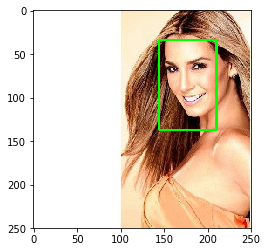

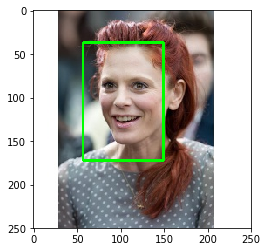

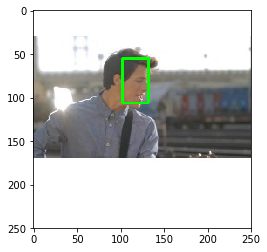

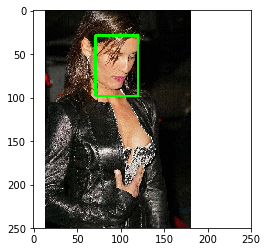

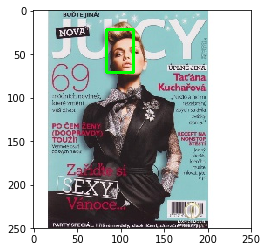

In [5]:
def predict(img):
    img_normalised = img / 255. #standardise image
    prediction = model.predict(img_normalised.reshape(1, img.shape[0], img.shape[1], img.shape[2]))
    return prediction

def plot_result(img, prediction):
    #we need to reverse the RGB channels, otherwise 'matplotlib.pyplot' gets confused
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #mark the face
    img = mark_face(img, prediction[0])
    #show the result
    plt.imshow(img)
    plt.show()
    
images = sorted(glob('celebfaces/images/*.jpg'))
for image in images[0:5]:
    img = cv2.imread(image)
    prediction = predict(img)
    plot_result(img, prediction)

It works quite well already, but in the third and the last image *the face isn't marked completely*. We will update the model on these images and re-run the prediction so you can see the model indeed updates.


***

## 2. Resuming training on a previously saved model

Training deep learning models can take a lot of time, especially with larger architectures and/or on larger datasets. You might need your computer for something else in between. Keras provides options so you can easily interrupt training and resume later. In this exercise you will learn how by updating the model we've loaded in the previous section.

***

In the previous section you loaded the celebfaces model. It will now behave just like any normal Keras model, and you've learned to deal with these in the previous notebooks already! This means you already know how to update the model with new data.

Let's update the model now by running a short training session on 50 images. We will limit the training phase to save you time, since the exercise is only about illustrating the process. In fact, we will do something wrong, **can you spot our mistake?**

First run the cell below to load the images and labels into memory and normalise them.

In [6]:
def load_images(images):
    output = []
    for image in images:
        im = cv2.imread(image)
        im = im / 255. #normalise image pixel values
        output.append(im)
    return np.asarray(output)

images = glob('celebfaces/images/*.jpg')
X = load_images(images)
Y = np.memmap('celebfaces/Y.npy', dtype=np.float32, mode='r', shape=(50, 4))
Y = Y / 250. #original images + labels are 250x250px, normalise labels

Your exercise is now to fit the model. Once you run the cell it might take a few minutes to complete. Use the following settings:

- X, Y for training data, training labels
- 4 epochs is enough for now
- use a batch size of 8

[hint](https://keras.io/models/model/#fit)

In [7]:
##Add your code here (approx 1 line)
history = model.fit(X, Y, epochs=4, batch_size=8)

Epoch 1/4
50/50 [==============================] - 5s 90ms/step - loss: 0.0482 - acc: 0.8800
Epoch 2/4
50/50 [==============================] - 1s 13ms/step - loss: 0.0401 - acc: 0.9200
Epoch 3/4
50/50 [==============================] - 1s 13ms/step - loss: 0.0330 - acc: 0.9600
Epoch 4/4
50/50 [==============================] - 1s 13ms/step - loss: 0.0325 - acc: 0.9400


You should've seen the model go through training and the loss changing. It's ok if the accuracy drops (it might, it might not): we are using a very small training set so the model likely has some issues fitting the new data in with so short a training window and so few examples (50). The overall loss should decrease nonetheless as the weights update to better accomodate the new data.

Run the cell below to re-evaluate performance on the third and fifth image on which it didn't do too well.

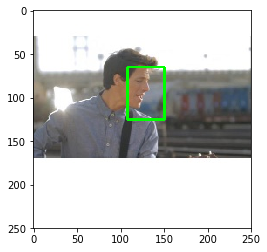

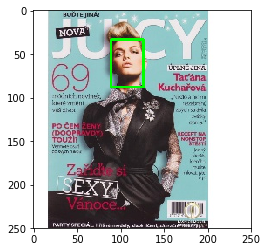

In [8]:
imgs = ['celebfaces/images/000003.jpg', 'celebfaces/images/000005.jpg']

for im in imgs:
    img = cv2.imread(im)
    prediction = predict(img)
    plot_result(img, prediction)

Cool! The prediction has indeed changed for the better, showing our model weights have been updated.

### However, think about this:
We have predicted on an image that we also used to update the model weights (train it) on. We've done this to show you the weights do indeed change without requiring you to wait through long training sessions. **Can you explain why this doesn't necessarily mean our model has improved? Why would you (not) use this approach to update your own models?** If you don't know, ask us. This is a really important point. The answer relates to the mistake we made.

***

We used a few memes in the previous notebook, of course you could opt to run the model on them:

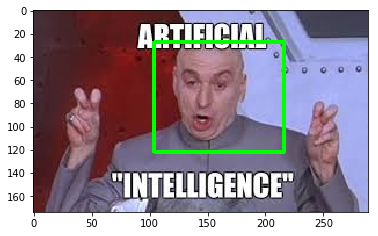

In [9]:
img = cv2.imread('artificialintelligence.jpg')
prediction = predict(img)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = mark_face(img, prediction[0], dx=img.shape[1], dy=img.shape[0])
plt.imshow(img)
plt.show()

## 3. Saving an updated model

Saving a model in Keras is very easy. The model class has its own 'save()' method. You can simply call this and specify a filename. Use the 'hdf5' extension as this is the data format used by Keras models. 

Your task now is to save the model.

- Use the .save() functionality.
- use filename: 'celebfaces/newmodel.hdf5'

In [10]:
##Add your code here (approx 1 line)
model.save('celebfaces/my_awesome_model.hdf5')
##End of your code

print(glob('celebfaces/*.hdf5'))

['celebfaces\\celebfaces_model.hdf5', 'celebfaces\\my_awesome_model.hdf5']


You should see "my_awesome_model.hdf5" appear in the detected files. You can find the model in the 'celebfaces' subfolder of this notebook.


### Moving away from Keras
There may be situations where you need to run your models on a different platform. You could begin again from scratch on the new platform, but usually you don't need to. Remember the model consists of an architecture as well as the weights, and it's the weights that are trained.

Using the .save() function you actually save both the model architecture and its weights, as well as things like optimizer state. **You can also save them separately**, which makes migrating to a different deep learning toolkit easier. Usually these toolkits have ways to cross-import model weights.

- To do so, simply use the **.save_weights()** function. 
- You can also save the model architecture separately to a JSON file for easy interchange.

We demonstrate both methods below.

In [11]:
#save model weights
model.save_weights('celebfaces/my_awesome_weights.hdf5')

#save model architecture to JSON
model_json = model.to_json() #creates a JSON memory object
with open("celebfaces/awesome_model.json", "w") as f: #we open a file object
    f.write(model_json) #we stream the JSON memory object to the file
    
print(glob('celebfaces/*.hdf5'))
print(glob('celebfaces/*.json'))

['celebfaces\\celebfaces_model.hdf5', 'celebfaces\\my_awesome_model.hdf5', 'celebfaces\\my_awesome_weights.hdf5']
['celebfaces\\awesome_model.json']


## 4. Using a data generator with very large datasets

Once you graduate from using smaller, 'toy' datasets into real-world deep learning problems, you run into massive datasets. For example, UC Berkeley recently open sourced a large dataset for training deep learning networks for use in traffic, the [Berkeley Deep Drive dataset](https://bdd-data.berkeley.edu/). This specific dataset contains **100,000 videos and 120,000,000 images!** Although this is large even for many deep learning sets, sizes like these are not uncommon, and many datasets will be millions of images large.

In the examples so far we've simply loaded all image data and labels into memory and used that. We cannot do this with large datasets. For example, assuming a set of 'only' 10,000 colour images of 720p resolution, we would need: (1280 \* 720 \* 3 \* 32) \* 10,000 = 884,736,000,000 bits, or approximately **110 gigabytes of memory**, simply to store them in a numpy array in memory. Your average laptop has 8 to 16 gigabytes of memory. Now imagine what you would need for the full set of 120,000,000 images... This is simply impossible.

***

Luckily the solution is simple: we only load the images the model needs, and only when it needs them. In other words: we generate each batch on the fly.

Keras can work with so-called 'data generators' that do exactly this.

**Note** that this example requires some more advanced understanding of python. For this reason, and because data generators are super useful, we will give you a basic example and explain what it does with comments in the code.

In [12]:
def load_data(filelist):
    X = []
    for f in files:
        img = cv2.imread(f)
        X.append(X)
    return np.asarray(X)

def myGenerator(batch_size=10):
    #Instead of loading images, we load the paths to the images.
    #This makes sure we don't use a lot of memory, even for massive datasets!
    # As a working example we load the 50 celebface images
    X_files = glob('celebfaces/images/*.jpg')
    #count how many files we have
    num_files = len(X_files)
    
    #We do load all the labels into memory, since these do not use a lot of memory anyway
    Y_labels = np.memmap('celebfaces/Y.npy', dtype=np.float32, mode='r', shape=(50, 4))
    #don't forget to check if labels also need standardisation, in this set they do!
    Y_labels = Y_labels / 250.
    
    #calculate the number of epochs given the training size and batch size
    num_epochs = num_files / epochs
    
    #Data generators need to be able to run infinitely
    #we simply use an always True statment
    while True: 
        #loop over each epoch
        for i in range(num_epochs):
            #load the data (you would define your own function to do so)
            files = X_files[i * batch_size : (i + 1) * batch_size]
            #load the files into array X with function load_data()
            X = load_data(files)
            #retrieve corresponding labels
            Y = Y_labels[i * batch_size : (i + 1) * batch_size]
            #yield is the same as 'return', except 'return' terminates the function execution whereas 'yield' does not
            yield X, Y